# Dynamics of an elastic beam: explicit time integration
In this notebook, we investigate the dynamics of an elastic beam using a linear and a nonlinear model. The beam is subjected to an external traction at one of its two ends over a short time period. We compute the dynamics of the beam using an explicit time-stepping scheme.


In [2]:
import dolfin
import numpy as np
import matplotlib.pyplot as plt
import ufl
import time

dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["optimize"] = True

In [3]:
use_linear_model = True
use_lumped_mass = False

### Definition of the geometry and the mesh

We consider a cantilever beam of size `Lx × Ly` (2D, plane stress), fixed at its `x = 0` end, and subjected to a an axial load at `x = Lx`. 

In [4]:
p1 = dolfin.Point(0., 0.)
p2 = dolfin.Point(1., 0.1)

ny = 10
nx = 10*ny

mesh = dolfin.RectangleMesh(p1, p2, nx, ny)

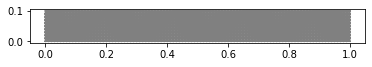

In [5]:
dolfin.plot(mesh)

In [6]:
left = dolfin.CompiledSubDomain("on_boundary && near(x[0],0)")
right = dolfin.CompiledSubDomain("on_boundary && near(x[0], L)", L=p2.x())

boundary_indices = {"left": 0, "right": 1}
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
left.mark(boundary_markers, boundary_indices["left"])
right.mark(boundary_markers, boundary_indices["right"])

ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)

### Material, loading and time-discretization parameters

A time-dependent traction is applied at the $x = L_x$ face as follows
$$
\vec T = \begin{cases}
\displaystyle\frac{t}{t_{\mathrm{c}}}\vec T_{\mathrm{max}} & t \leq t_{\mathrm{c}}\\[.2em]
\vec 0 & t > t_{\mathrm{c}}
\end{cases}
$$
where $t_{\mathrm{c}}$ is a “cut-off” time. Note that depending on the direction of the applied traction, we will need to select different values for `t_c` and `T_max`.

In [81]:
Y  = 10.
nu = 0.3
mu = dolfin.Constant(Y/(2.*(1.+nu)))
lambda_ = Y*nu/((1.+nu)*(1.-2.*nu))
lambda_ = dolfin.Constant(2*lambda_*mu/(lambda_+2*mu))
rho = dolfin.Constant(1.)

eta_m = dolfin.Constant(0.01)
eta_k = dolfin.Constant(0.00001)

eta_m_v = 0.1
eta_k_v = 0.0001

eta_m = dolfin.Constant(eta_m_v)
eta_k = dolfin.Constant(eta_k_v)

t_end = 3.
num_steps  = 5*800
# num_steps  = 800
dt = t_end/num_steps

t_cutoff = .1
traction_max = 1.0

vertical_traction = True
expr = ["0", "t <= t_cutoff ? traction_max*t/t_cutoff : 0"] if vertical_traction else ["t <= t_cutoff ? traction_max*t/t_cutoff : 0", "0"]
# expr = ["0", "t <= t_cutoff ? traction_max*t/t_cutoff : 0"]

traction = dolfin.Expression(expr, t=0, t_cutoff=t_cutoff, traction_max=traction_max, degree=0)

### Definition of the problem in the linear and in the nonlinear case (finite deformations)

In [8]:
V = dolfin.VectorFunctionSpace(mesh, "CG", 1)

In [9]:
zero = dolfin.Constant((0,0))
bc = dolfin.DirichletBC(V, zero, left)

In [69]:
# Kinematics nonlinear case
I2 = dolfin.Identity(2) # Identity tensor
def stress_nonlinear(u):  
    F = ufl.variable(I2 + ufl.grad(u))  
    CC = F.T*F                   
    Ic = ufl.tr(CC)
    J  = ufl.det(F)
    E = 1/2*(CC-I2)
# Stored strain energy density (compressible neo-Hookean model)
# Elasticity parameters (plane-stress)
#    psi = lambda_*ufl.tr(E)**2/2+mu*ufl.inner(E,E)
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2
    return ufl.diff(psi, F) 

def energy_nonlinear(u):  
    F = ufl.variable(I2 + ufl.grad(u))  
    CC = F.T*F                   
    Ic = ufl.tr(CC)
    J  = ufl.det(F)
    E = 1/2*(CC-I2)
# Stored strain energy density (compressible neo-Hookean model)
# Elasticity parameters (plane-stress)
#    psi = lambda_*ufl.tr(E)**2/2+mu*ufl.inner(E,E)
    psi = (mu/2)*(Ic - 2) - mu*ufl.ln(J) + (lambda_/2)*(ufl.ln(J))**2
    return psi*dx

def stiffness_nonlinear(u, v):
    return dolfin.inner(stress_nonlinear(u),dolfin.grad(v))*dx

In [11]:
# Kinematics linear case
def stress_linear(eps):
    return lambda_*dolfin.tr(eps)*I2+2.*mu*eps

def strain_displacement(u):
    return dolfin.sym(dolfin.grad(u))

def stiffness_linear(u, v):
    return dolfin.inner(stress_linear(strain_displacement(u)),
                        strain_displacement(v))*dx                     

In [82]:
if use_linear_model:
    stiffness = stiffness_linear
else:
    stiffness = stiffness_nonlinear    

def mass(u, v):
    return rho*dolfin.inner(u, v)*dx

def damping(u, v):
    return eta_m*mass(u, v)+eta_k*stiffness_linear(u, v)

def p_ext(u):
    return dolfin.dot(u, traction)*ds(boundary_indices["right"])

In [13]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

M = dolfin.assemble(mass(u, v))

In [14]:
# Compute the sum of the rows of the mass matrix
# Only for the case of a lumped mass matrix
m = mass(u, v)
ones = dolfin.Constant((1.,1.))
M_lumped = dolfin.assemble(dolfin.action(m, ones))
M_lumped_inv = 1./M_lumped.get_local()

In [15]:
bc.apply(M)

In [16]:
u = dolfin.Function(V)
v = dolfin.Function(V)

In [17]:
u_vec = u.vector()
v_vec = v.vector()

In [18]:
vector = dolfin.Vector()
M.init_vector(vector, 1)
    
a_vec = vector

In [19]:
if not use_lumped_mass:
    solver = dolfin.LUSolver(M)

In [48]:
coords_tip = p2.array()[:2]
coords_tip[1] *= 0.5

times = dt*np.arange(num_steps+1, dtype=np.float64)
displ_tip = np.zeros_like(times)

energies = np.zeros((num_steps+1, 4), dtype=np.float64)
E_damp = 0
E_elas = 0
E_ext = 0

### Explicit time-stepping scheme

In [83]:
u_vec.zero()
v_vec.zero()
a_vec.zero()

time_solve = 0.
for n in range(num_steps):
    traction.t = (n+1)*dt
    f = dolfin.assemble(p_ext(dolfin.TestFunction(V)))
    f_int = dolfin.assemble(stiffness(u,dolfin.TestFunction(V)))
    f_damp = dolfin.assemble(damping(v,dolfin.TestFunction(V)));
    f.axpy(-1., f_int)
    f.axpy(-1., f_damp)    
    bc.apply(f)
    t1 = time.perf_counter()
    if use_lumped_mass:
        a_vec[:] = M_lumped_inv*f[:]        
    else:
        solver.solve(a_vec, f)
    t2 = time.perf_counter()
    time_solve += t2-t1
    
# Corrector step
    v_vec.axpy(dt, a_vec)
    u_vec.axpy(dt, v_vec)
    
    
    displ_tip[n+1] = u(coords_tip)[1] if vertical_traction else u(coords_tip)[0]
    
    if use_linear_model:
        E_elas = dolfin.assemble(0.5*stiffness(u, u))
    else:
        E_elas = dolfin.assemble(energy_nonlinear(u))
    
    E_kin = dolfin.assemble(0.5*mass(v, v))
    E_damp += dt*dolfin.assemble(damping(v, v))
    E_tot = E_elas+E_kin+E_damp
    energies[n+1, :] = np.array([E_elas, E_kin, E_damp, E_tot])

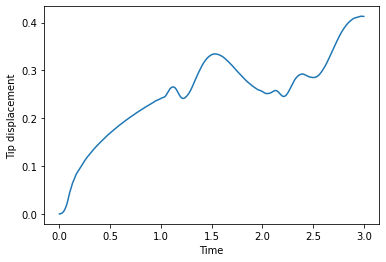

In [84]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

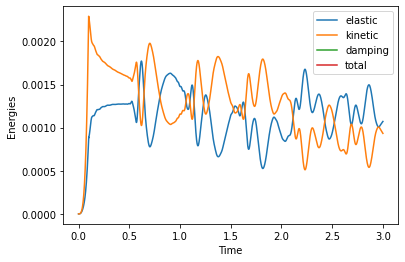

In [85]:
plt.figure()
plt.plot(times, energies)
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

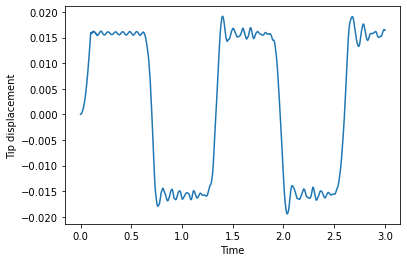

In [21]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

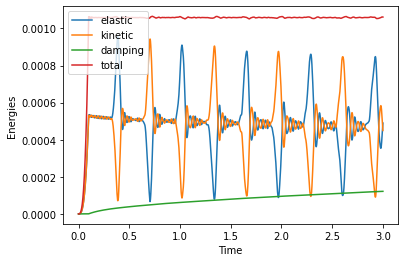

In [22]:
plt.figure()
plt.plot(times, energies)
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

In [23]:
print("Temps de calcul des accélérations {:.2f}s".format(time_solve))
dt_crit = mesh.rmin()/np.sqrt(Y/rho.values())
print("Pas de temps critique {:.2e}s".format(dt_crit[0]))
print("Pas de temps utilisé {:.2e}s".format(dt))

Temps de calcul des accélérations 1.25s
Pas de temps critique 9.26e-04s
Pas de temps utilisé 7.50e-04s


# Exercise

**1)** Change the values of the damping parameters and describe how this modifies the displacement and energy plots. 


**2)** Change the number of time steps and observe what happends when $dt >dt_{crit}$, explain.


**3)** Modify the orientation of the applied traction.


**4)** Do you observe a significant difference when you use the lumped mass matrix instead of the usual mass matrix?


**5)** How does the difference in computational time between these two approaches (lumped mass or standard mass) vary with the size of the mesh?

**6)** Compare the prediction of the linear model with the results obtained with the nonlinear model for the same loading conditions (start with a small applied traction and then try a larger traction). 

**1)** Change the values of the damping parameters and describe how this modifies the displacement and energy plots. 

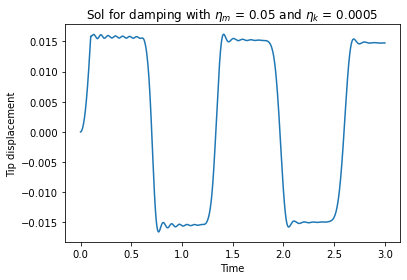

In [54]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ' and ' + r'$\eta_k$ = ' + str(eta_k_v))
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

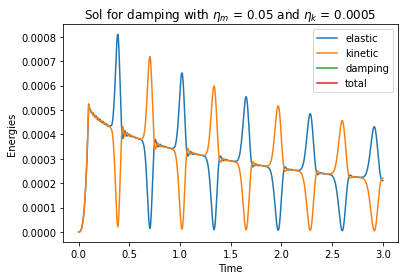

In [55]:
plt.figure()
plt.plot(times, energies)
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ' and ' + r'$\eta_k$ = ' + str(eta_k_v))
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

**2)** Change the number of time steps and observe what happends when $dt >dt_{crit}$, explain.


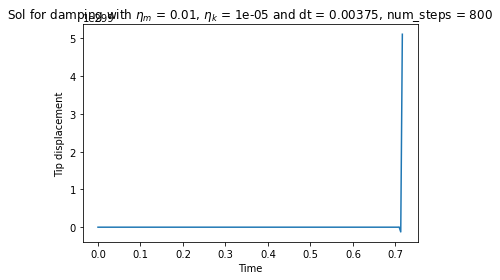

In [64]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ', ' + r'$\eta_k$ = ' + str(eta_k_v) + ' and dt = ' + str(dt) + ', num_steps = ' + str(num_steps))
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

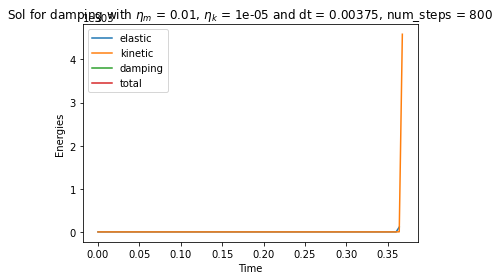

In [66]:
plt.figure()
plt.plot(times, energies)
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ', ' + r'$\eta_k$ = ' + str(eta_k_v) + ' and dt = ' + str(dt) + ', num_steps = ' + str(num_steps))
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

**3)** Modify the orientation of the applied traction.


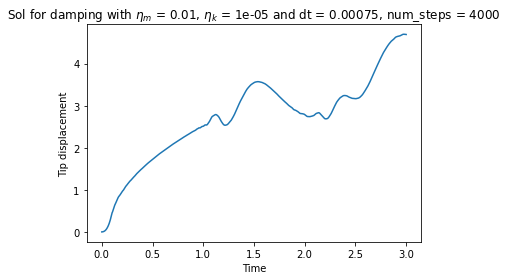

In [45]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ', ' + r'$\eta_k$ = ' + str(eta_k_v) + ' and dt = ' + str(dt) + ', num_steps = ' + str(num_steps))
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

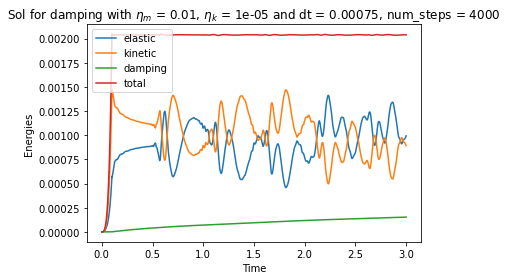

In [29]:
plt.figure()
plt.plot(times, energies)
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ', ' + r'$\eta_k$ = ' + str(eta_k_v) + ' and dt = ' + str(dt) + ', num_steps = ' + str(num_steps))
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()

**4)** Do you observe a significant difference when you use the lumped mass matrix instead of the usual mass matrix?


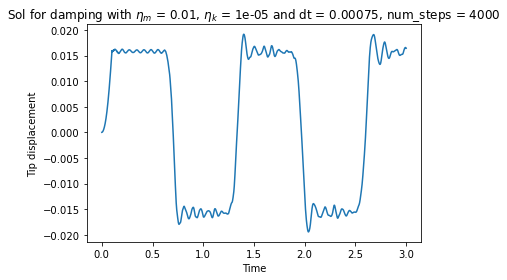

In [95]:
plt.figure()
plt.plot(times, displ_tip, '-')
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ', ' + r'$\eta_k$ = ' + str(eta_k_v) + ' and dt = ' + str(dt) + ', num_steps = ' + str(num_steps))
plt.xlabel("Time")
plt.ylabel("Tip displacement")
plt.savefig("tip_displacement.png")

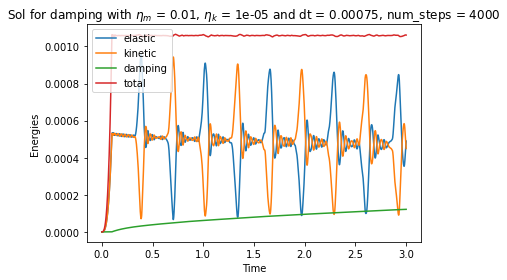

In [96]:
plt.figure()
plt.plot(times, energies)
plt.title('Sol for damping with ' + r'$\eta_m$ = ' + str(eta_m_v) + ', ' + r'$\eta_k$ = ' + str(eta_k_v) + ' and dt = ' + str(dt) + ', num_steps = ' + str(num_steps))
plt.legend(("elastic", "kinetic", "damping", "total"))
plt.xlabel("Time")
plt.ylabel("Energies")
plt.show()